In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import h5py
import tqdm
import zipfile
from tqdm.notebook import tqdm_notebook
from progress.bar import IncrementalBar
import random
# tf.config.run_functions_eagerly(True)
%matplotlib inline

In [2]:
with h5py.File("mc_wfmax_norm.h5",'r') as f:
    print(list(f.keys()))
    norm_param=f['norm_param'][:]
    test=f['test'][:]
    train=f['train'][:472320]
    print(f['train'].shape)
# mean=train.mean()
# train=train-mean
# train=train/(np.absolute(train)).max()
train=(train+1)/2
test=(test+1)/2
print(train.min(),train.max(),train.mean())
print(len(train))
print(norm_param)

['norm_param', 'test', 'train']
(472351, 128, 2)
0.0 1.0 0.025971571
472320
[[ 0.04490717  0.04396976]
 [-0.99174523 -0.9909725 ]]


In [3]:
#HYPER PARAMETERS
noise_dim=200
shape_data=train[0].shape
shape=(128,2)
# generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0, beta_2=0.9)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0, beta_2=0.9)
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
scal_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0, beta_2=0.9)

In [4]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


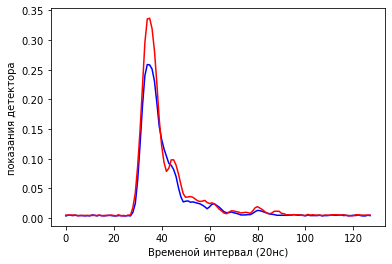

In [5]:
a=train[20,:,0]
b=train[20,:,1]
plt.plot(a,'b')
plt.plot(b,'r')
plt.xlabel("Временой интервал (20нс)")
plt.ylabel('показания детектора')
plt.savefig('dip_1.png')

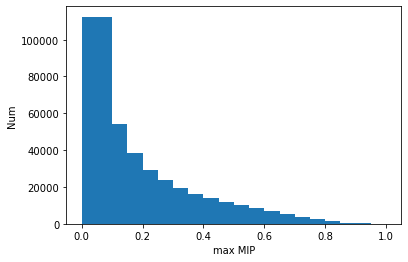

In [6]:
max_el=np.zeros(len(train))
for i in range(len(train)):
    max_el[i]=train[i].max()
    
# print(len(max_el))    
num,interval,pl=plt.hist(max_el,20,(0,1))
plt.xlabel('max MIP')
plt.ylabel('Num')
plt.savefig('real_hist.png')

In [7]:
train=train[train.max(axis=1).max(axis=1)>0.2]
train.shape
train=train[:2425*64]
train.shape

(155200, 128, 2)

In [8]:
generator=tf.keras.models.load_model('WGAN_more0.2/save_model/discriminator/ep280')
generator.summary()

Model: "Discriminator_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 2)]          0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 148, 2)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 74, 64)            1344      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 37, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 64)            0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 37, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 37, 128)   

Model: "Discriminator_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 148, 2)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 74, 64)       1344        zero_padding1d[0][0]             
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 37, 64)       0           conv1d[0][0]                     
________________________________________________________________________________

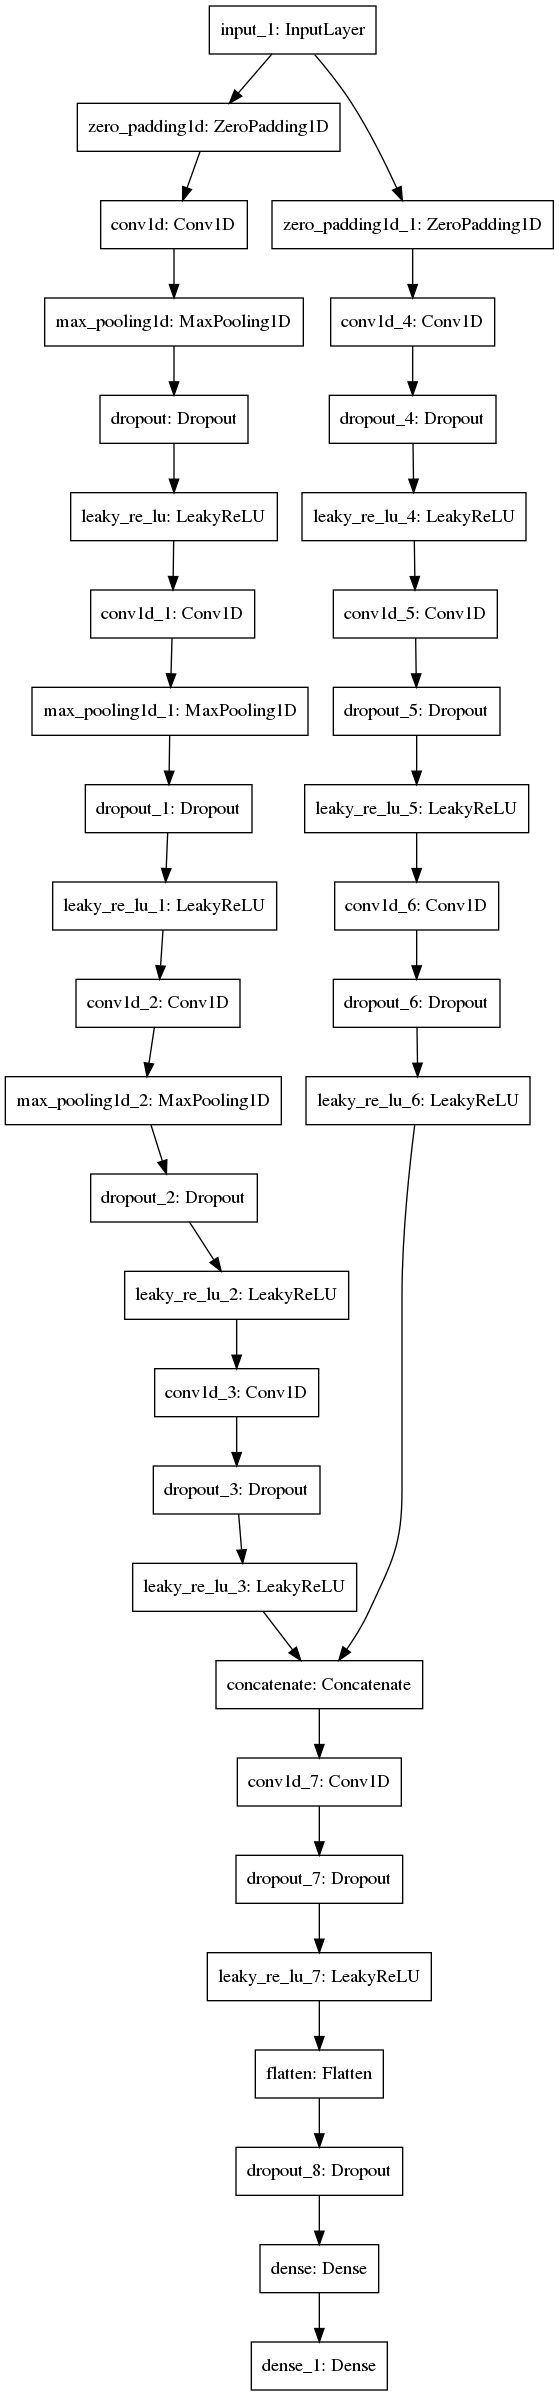

In [9]:
#copy Most active detector
def Discriminator_model():
    input_tensor=tf.keras.Input(shape=(128,2))
    x= input_tensor
    
    x=tf.keras.layers.ZeroPadding1D(10)(x)
    
    
    x=tf.keras.layers.Conv1D(filters=64, kernel_size=(10), strides=(2), padding='same')(x)
    x=tf.keras.layers.MaxPooling1D(2,padding='same')(x)
    x=tf.keras.layers.Dropout(rate=0.2)(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
    x=tf.keras.layers.Conv1D(filters=128, kernel_size=(5), strides=(1), padding='same')(x)
    x=tf.keras.layers.MaxPooling1D(2,padding='same')(x)
    x=tf.keras.layers.Dropout(rate=0.2)(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
    x=tf.keras.layers.Conv1D(filters=128, kernel_size=(5), strides=(1), padding='same')(x)
    x=tf.keras.layers.MaxPooling1D(2,padding='same')(x)
    x=tf.keras.layers.Dropout(rate=0.2)(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
    x=tf.keras.layers.Conv1D(filters=128, kernel_size=(5), strides=(1), padding='same')(x)
    x=tf.keras.layers.Dropout(rate=0.2)(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
    
#     x=tf.keras.layers.BatchNormalization()(x)
    y=tf.keras.layers.ZeroPadding1D(10)(input_tensor)
    y=tf.keras.layers.Conv1D(filters=64, kernel_size=(10), strides=(4), padding='same')(y)
    y=tf.keras.layers.Dropout(rate=0.2)(y)
    y=tf.keras.layers.LeakyReLU()(y)
    
    y=tf.keras.layers.Conv1D(filters=128, kernel_size=(5), strides=(2), padding='same')(y)
    y=tf.keras.layers.Dropout(rate=0.2)(y)
    y=tf.keras.layers.LeakyReLU()(y)
    
    y=tf.keras.layers.Conv1D(filters=128, kernel_size=(5), strides=(2), padding='same')(y)
    y=tf.keras.layers.Dropout(rate=0.2)(y)
    y=tf.keras.layers.LeakyReLU()(y)
    
    x=tf.keras.layers.concatenate((x,y))
    x=tf.keras.layers.Conv1D(filters=128, kernel_size=(5), strides=(1), padding='same')(x)
    x=tf.keras.layers.Dropout(rate=0.2)(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
    x=tf.keras.layers.Flatten()(x)
    
    #LSTM
    
#     x=tf.keras.layers.LSTM(20,activation=tf.keras.activations.linear)(x)
#     x=tf.compat.v1.keras.layers.CuDNNLSTM(1)(x)
    
    
    x=tf.keras.layers.Dropout(rate=0.1)(x)
#     x=tf.keras.layers.Dense(units=100)(x)
#     x=tf.keras.layers.ReLU()(x)

    x=tf.keras.layers.Dense(units=100,activation='relu')(x)
    x=tf.keras.layers.Dense(units=1)(x)
    
    model= tf.keras.Model(input_tensor,x,name="Discriminator_model")
    return model

discriminator=Discriminator_model()
discriminator.summary()
tf.keras.utils.plot_model(discriminator)

In [10]:
#copy Most active detector
def Discriminator_model():
    input_tensor=tf.keras.Input(shape=(128,2))
    x= input_tensor
    
    x=tf.keras.layers.ZeroPadding1D(10)(x)
#     x=tf.keras.layers.Conv1D(filters=32, kernel_size=(5), strides=(1), padding='same')(x)
#     x=tf.keras.layers.LeakyReLU()(x)

    x=tf.keras.layers.Conv1D(filters=32, kernel_size=(5), strides=(1), padding='same',name="first")(x)
    x=tf.keras.layers.MaxPooling1D(2,padding='same')(x)
    x=tf.keras.layers.Dropout(rate=0.2)(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.Conv1D(filters=64, kernel_size=(5), strides=(1), padding='same')(x)
    x=tf.keras.layers.MaxPooling1D(2,padding='same')(x)
    x=tf.keras.layers.Dropout(rate=0.2)(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
    x=tf.keras.layers.Conv1D(filters=64, kernel_size=(5), strides=(1), padding='same')(x)
    x=tf.keras.layers.MaxPooling1D(2,padding='same')(x)
    x=tf.keras.layers.Dropout(rate=0.2)(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
    x=tf.keras.layers.Conv1D(filters=64, kernel_size=(5), strides=(1), padding='same')(x)# kern=4
    x=tf.keras.layers.MaxPooling1D(2,padding='same')(x)
    x=tf.keras.layers.Dropout(rate=0.2)(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
    x=tf.keras.layers.Conv1D(filters=128, kernel_size=(5), strides=(1), padding='same')(x)# kern=4
    x=tf.keras.layers.MaxPooling1D(2,padding='same')(x)
    x=tf.keras.layers.Dropout(rate=0.2)(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
    x=tf.keras.layers.Flatten()(x)
    x=tf.keras.layers.Dropout(rate=0.1)(x)

    x=tf.keras.layers.Dense(units=100,activation='relu')(x)
    x=tf.keras.layers.Dense(units=1)(x)
    
    model= tf.keras.Model(input_tensor,x,name="Discriminator_model")
    return model

discriminator=Discriminator_model()
discriminator.summary()
# tf.keras.utils.plot_model(discriminator)

Model: "Discriminator_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 2)]          0         
_________________________________________________________________
zero_padding1d_2 (ZeroPaddin (None, 148, 2)            0         
_________________________________________________________________
first (Conv1D)               (None, 148, 32)           352       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 74, 32)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 74, 32)            0         
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 74, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 74, 64)    

In [11]:
def Generator_model(): 
    input_tensor=tf.keras.Input(shape=(noise_dim,))
    x=tf.keras.layers.Dense(units=200,use_bias=False)(input_tensor)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
    x=tf.keras.layers.Dense(units=33*6,use_bias=False)(x)
    x=tf.keras.layers.Dropout(rate=0.1)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
    x=tf.keras.layers.Reshape((33,6,1))(x)
    
    x=tf.keras.layers.Conv2DTranspose(128, (5,1), strides=(2,1), padding='same', use_bias=False,data_format='channels_last')(x)
    x=tf.keras.layers.Dropout(rate=0.1)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
    x=tf.keras.layers.Conv2DTranspose(64, (5,1), strides=(2,1), padding='same', use_bias=False,data_format='channels_last')(x)
    x=tf.keras.layers.Dropout(rate=0.1)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
#     print(x.shape)
    x=tf.keras.layers.Conv2DTranspose(32, (5,1), strides=(2,1), padding='same', use_bias=False,data_format='channels_last')(x)
    x=tf.keras.layers.Dropout(rate=0.1)(x)
    
    x=tf.keras.layers.AveragePooling2D((2,1),padding='same')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
#     x=tf.keras.layers.Conv2DTranspose(16, (5,1), strides=(2,1), padding='same', use_bias=False,data_format='channels_last')(x)
#     x=tf.keras.layers.Dropout(rate=0.1)(x)
#     x=tf.keras.layers.BatchNormalization()(x)
#     x=tf.keras.layers.LeakyReLU()(x)
    
    x=tf.keras.layers.Conv2DTranspose(8, (7,1), strides=(2,1), padding='same', use_bias=False,data_format='channels_last')(x)
    x=tf.keras.layers.Dropout(rate=0.1)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.layers.AveragePooling2D((2,1),padding='same')(x)
    
#     print(x.shape)
    x=tf.keras.layers.Conv2D(1, (9,1), strides=(1,1), padding='same', use_bias=False,data_format='channels_last')(x)
    x=tf.keras.layers.Dropout(rate=0.1)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.activations.sigmoid(x)
    x=tf.keras.layers.Cropping2D((2,2))(x) #change
    x=tf.keras.layers.Reshape((128,2))(x)

    model= tf.keras.Model(input_tensor,x,name="Generator_model")
#     assert model.output_shape == (None, 128, 2, 1)
    return model
# kern 3,4,5,5,|^ 
# kern (n,2)
generator=Generator_model()
generator.summary()

Model: "Generator_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40000     
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 198)               39600     
_________________________________________________________________
dropout_15 (Dropout)         (None, 198)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 198)           

In [12]:
#check work moedls
batch=64
noise = tf.random.normal(shape=(batch,noise_dim))
data=generator(noise)
print(generator(noise).shape)
print(discriminator(generator(noise)).shape)
tf.reduce_max(data,axis=1).shape

(64, 128, 2)
(64, 1)


TensorShape([64, 2])

In [13]:
def generat_new_data(batch):
    noise=tf.random.normal(shape=(batch,noise_dim))
    #n_scal=tf.random.normal(shape=(batch,scal_dim))#change
    data=generator(noise)#*scal(n_scal)#change
    return (data)



def discriminator_loss(real_output, fake_output):
#     real_loss = loss_function(tf.ones_like(real_output), real_output)
#     fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    real_loss = -tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
#     return loss_function(tf.ones_like(fake_output), fake_output)
    return -tf.reduce_mean(fake_output)

def gradient_penalti(batch,real_data,fake_data):
#   alpha = tf.random.normal([batch, 1], 0.0, 1.0)
#   diff = fake_data - real_data
#   interpolated = real_data + alpha * diff
    epsilon=tf.random.uniform(shape=(batch,1,1),dtype=tf.dtypes.float32)
    interpolated=real_data-epsilon*(real_data-fake_data)# вычисление x^ как в статье
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred=discriminator(interpolated,training=True)  # D(x^)
    grads = gp_tape.gradient(pred, [interpolated])[0]# because list
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp    


In [14]:
@tf.function
def train_step_WGAN(labda,batch,real_data,weight_gp,weight_corr):
  # labda --> number learling critic
  #weight --> weight gradient_penalti

  #learning critic
    for i in range(labda):
        with tf.GradientTape() as gr:
            noise = tf.random.normal(shape=(batch,noise_dim))
            fake_data=generator(noise)#change
#             print('f')
            real_data=real_data
            fake_predict=discriminator(fake_data)
            real_predict=discriminator(real_data)
            real_data=tf.cast(real_data,dtype=tf.float32)
            gp=gradient_penalti(batch,real_data,fake_data)
            disc_loss=discriminator_loss(real_predict,fake_predict)+weight_gp*gp # critic loss include GP
        d_grad=gr.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(d_grad, discriminator.trainable_variables))


  #learning generator
    noise = tf.random.normal(shape=(batch,noise_dim))
    with tf.GradientTape() as gr:
        fake_data=generator(noise)
        fake_predict=discriminator(fake_data)
#         corr_loss=correletion_loss(fake_data)
        gen_loss=generator_loss(fake_predict)# +weight_corr*corr_loss
    
    
    
    
    g_grad=gr.gradient(gen_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(g_grad, generator.trainable_variables))
    return (gen_loss,disc_loss)
#     #change
    
#     print('f')
#     s_grad=gr.gradient(gen_loss,scal.trainable_variables)
#     print('g')
#     scal_optimizer.apply_gradients(zip(s_grad, scal.trainable_variables))
#     print('f')
#     return #change


In [15]:
noise_dim=200
num=5000
noise = tf.random.normal(shape=(num,noise_dim))
data_fake=generator(noise)
data_real=test[:num]
print(data_fake.shape,data_real.shape)
predict_fake=discriminator(data_fake)

(5000, 128, 2) (5000, 128, 2)


In [16]:
import os
dir_name="BA/WGAN_not_agr_mean3_(|^)"
os.mkdir(dir_name)
os.mkdir('{}/save_images'.format(dir_name))
os.mkdir('{}/save_model'.format(dir_name))

In [17]:
def image(n,num=10):
    fig, axes =plt.subplots(num,2,figsize=(50,50))
    

    for i in range(num):
        noise = tf.random.normal(shape=(1,noise_dim))
        axes[i,0].plot((generator(noise))[0,:,1],'r')#change
        axes[i,0].plot((generator(noise))[0,:,0],'b')
        j=random.randint(0,len(train))
        axes[i,1].plot(train[j,:,1],'r')
        axes[i,1].plot(train[j,:,0],'b')
        plt.suptitle("epoch:"+str(n))
        plt.savefig("{}/save_images/epoch{}.png".format(dir_name,n))
    
# image(20)

In [ ]:
batch=64
epochs=100
ep_start=0
g_list=[]
d_list=[]
def train_WGAN(epochs,train_data,batch):
    plt.figure()
    for j in tqdm_notebook(range(ep_start,epochs),'ep'):
        for num in range (0,len(train_data),batch):
            step_data=train_data[num:num+batch]
            g,d=train_step_WGAN(labda=5,batch=batch,real_data=step_data,weight_gp=10,weight_corr=1)
            d_list.append(d)
            g_list.append(g)
#             disc_loss_list.append(disc_loss)
#             gen_loss_list.append(gen_loss)
            #corr_loss_list1.append(corr_loss)
#         generator.save("del")
#         if (j % 10 == 0 or j <25):
        image(j)
        discriminator.save("{}/save_model/discriminator/ep{}".format(dir_name,j))
        generator.save("{}/save_model/generator/ep{}".format(dir_name,j))
train_WGAN(epochs,train,batch)

INFO:tensorflow:Assets written to: BA/WGAN_not_agr_mean3_(|^)/save_model/discriminator/ep0/assets
INFO:tensorflow:Assets written to: BA/WGAN_not_agr_mean3_(|^)/save_model/generator/ep0/assets
INFO:tensorflow:Assets written to: BA/WGAN_not_agr_mean3_(|^)/save_model/discriminator/ep1/assets
INFO:tensorflow:Assets written to: BA/WGAN_not_agr_mean3_(|^)/save_model/generator/ep1/assets
INFO:tensorflow:Assets written to: BA/WGAN_not_agr_mean3_(|^)/save_model/discriminator/ep2/assets
INFO:tensorflow:Assets written to: BA/WGAN_not_agr_mean3_(|^)/save_model/generator/ep2/assets


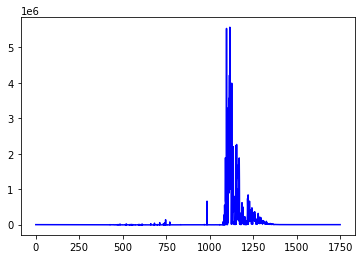

In [21]:
# plt.plot(g_list[250:2000],'r')
plt.plot(d_list[250:2000],'b')
# plt.ylim(-50, 50)

1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10


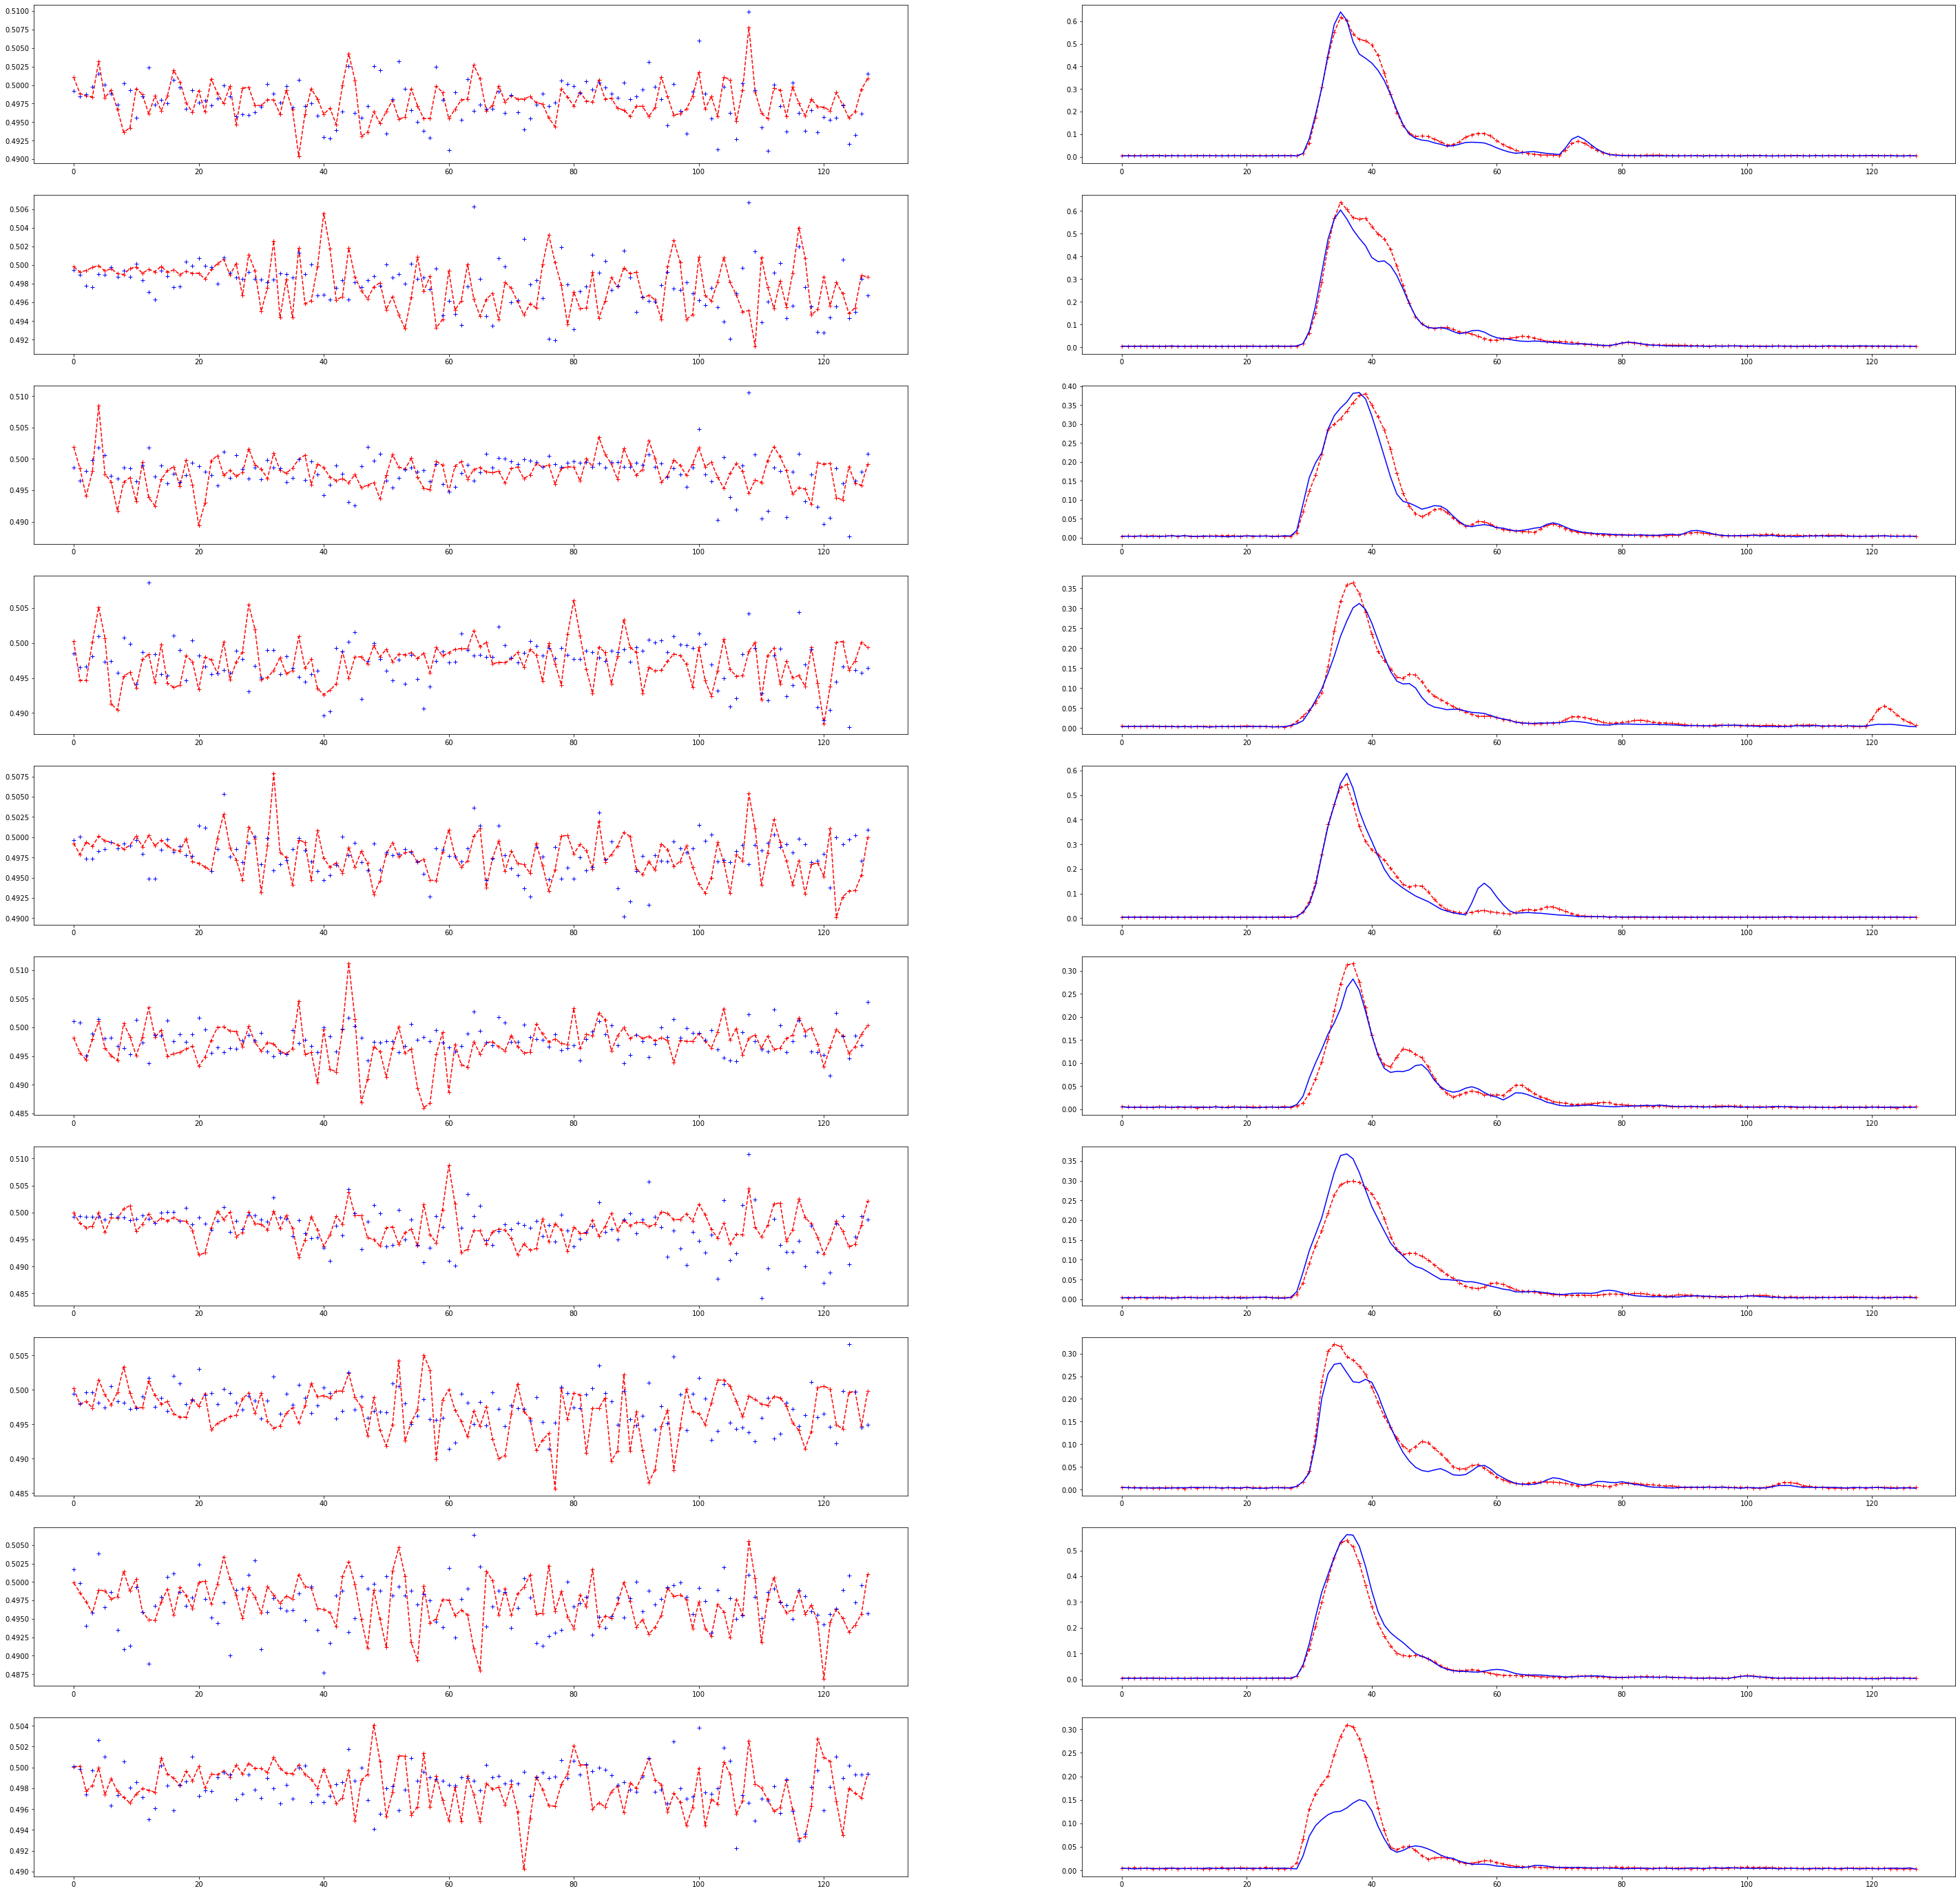

In [33]:
# generator=tf.keras.models.load_model('WGAN_4/save_model/generator/ep490')
z=random.randint(0,len(train)//2)
def big_ampl(val):
    noise = tf.random.normal(shape=(1000,noise_dim))
    data=generator(noise)
    fig, axes =plt.subplots(10,2,figsize=(50,50))
    j=0
    for i in range(len(data)):
        if tf.math.reduce_max(data[i])>val:
            axes[j,0].plot(data[i][:,1],'r--+')#change
            axes[j,0].plot(data[i][:,0],'b+')
            j+=1
            print(j)
            if j>9:
                break
    j=0
    for i in range(z,len(train)):
        if tf.math.reduce_max(train[i])>val:
            axes[j,1].plot(train[i][:,1],'r--+')#change
            axes[j,1].plot(train[i][:,0],'b')
            j+=1
            print(j)
            if j>9:
                break
big_ampl(0.3)

In [1]:
generator=tf.keras.models.load_model('WGAN_3/save_model/generator/ep280')
noise = tf.random.normal(shape=(2000,noise_dim))
data=generator(noise)
max_el=np.zeros(len(data))
for i in range(len(data)):
    max_el[i]=tf.math.reduce_max(data[i])
    
# print(len(max_el))    
plt.hist(max_el,20,(0,1))
plt.xlabel('max MIP')
plt.ylabel('Num')
plt.savefig('fake_hist.png')

NameError: name 'tf' is not defined

## for check 

Text(0, 0.5, 'Num')

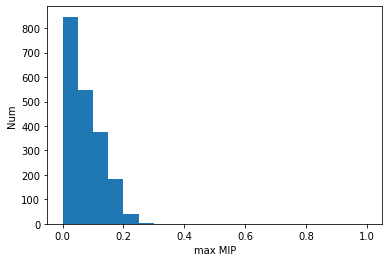

In [21]:
generator=tf.keras.models.load_model('NOT_WGAN_2/save_model/generator/ep490')
noise_dim=200
noise = tf.random.normal(shape=(2000,noise_dim))
data=generator(noise)
max_el=np.zeros(len(data))
for i in range(len(data)):
    max_el[i]=tf.math.reduce_max(data[i])
    
# print(len(max_el))    
plt.hist(max_el,20,(0,1))
plt.xlabel('max MIP')
plt.ylabel('Num')
# plt.savefig('fake_hist.png')

In [22]:
generator=tf.keras.models.load_model('WGAN_2/save_model/generator/ep490')
noise_dim=200
noise = tf.random.normal(shape=(2000,noise_dim))
data=generator(noise)
max_el=np.zeros(len(data))
for i in range(len(data)):
    max_el[i]=tf.math.reduce_max(data[i])
    
# print(len(max_el))    
plt.hist(max_el,20,(0,1))
plt.xlabel('max MIP')
plt.ylabel('Num')
# plt.savefig('fake_hist.png')

OSError: SavedModel file does not exist at: WGAN_2/save_model/generator/ep490/{saved_model.pbtxt|saved_model.pb}

## Проверка гениротора и дискриминатора

In [29]:
generator=tf.keras.models.load_model('NOT_WGAN_2/save_model/generator/ep490')
discriminator=tf.keras.models.load_model('NOT_WGAN_2/save_model/discriminator/ep490')
noise_dim=200
num=5000
noise = tf.random.normal(shape=(num,noise_dim))
data_fake=generator(noise)
data_real=test[:num]
print(data_fake.shape,data_real.shape)
predict_fake=discriminator(data_fake)
predict_real=discriminator(data_real)
print(tf.reduce_mean(predict_fake),tf.reduce_mean(predict_real))

(5000, 128, 2) (5000, 128, 2)
tf.Tensor(24.374641, shape=(), dtype=float32) tf.Tensor(24.467522, shape=(), dtype=float32)


## Обучение только дискриминатора

In [22]:
generator=tf.keras.models.load_model('NOT_WGAN_2/save_model/generator/ep490')
# discriminator=tf.keras.models.load_model('NOT_WGAN_2/save_model/discriminator/ep0')
@tf.function
def train_step_WGAN_only_disc(labda,batch,real_data,weight_gp,weight_corr):
  # labda --> number learling critic
  #weight --> weight gradient_penalti

  #learning critic
    for i in range(labda):
        with tf.GradientTape() as gr:
            noise = tf.random.normal(shape=(batch,noise_dim))
            fake_data=generator(noise)#change
#             print('f')
            real_data=real_data
            fake_predict=discriminator(fake_data)
            real_predict=discriminator(real_data)
            real_data=tf.cast(real_data,dtype=tf.float32)
            gp=gradient_penalti(batch,real_data,fake_data)
            disc_loss=discriminator_loss(real_predict,fake_predict)#+weight_gp*gp # critic loss include GP
        d_grad=gr.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(d_grad, discriminator.trainable_variables))


  
    return (disc_loss)
# import os
# os.mkdir('GAN_only_disc')
# os.mkdir('GAN_only_disc/save_images')
# os.mkdir('GAN_only_disc/save_model')
batch=64
epochs=501
ep_start=0
g_list=[]
d_list=[]
discriminator=tf.keras.models.load_model('NOT_WGAN_2/save_model/discriminator/ep200')
def train_WGAN_only_disc(epochs,train_data,batch):
    plt.figure()
    for j in tqdm_notebook(range(ep_start,epochs),'ep'):
        for num in range (0,len(train_data),batch):
            step_data=train_data[num:num+batch]
            d=train_step_WGAN_only_disc(labda=1,batch=batch,real_data=step_data,weight_gp=10,weight_corr=1)
            d_list.append(d)
#         if j % 10 == 0:
#             image(j)
#             discriminator.save("GAN_4_only_disc/save_model/discriminator/ep"+str(j))
train_WGAN_only_disc(epochs,train,batch)


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [23]:
disc=tf.keras.models.load_model('GAN_RNN/save_model/discriminator/ep150')
disc.summary()

Model: "Discriminator_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 2)]          0         
_________________________________________________________________
zero_padding1d_5 (ZeroPaddin (None, 148, 2)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 37, 64)            1344      
_________________________________________________________________
dropout_23 (Dropout)         (None, 37, 64)            0         
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 37, 64)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 19, 128)           82048     
_________________________________________________________________
dropout_24 (Dropout)         (None, 19, 128)   

In [64]:
discriminator=tf.keras.models.load_model('NOT_WGAN_2/save_model/discriminator/ep300')
noise_dim=200
num=5000
noise = tf.random.normal(shape=(num,noise_dim))
data_fake=generator(noise)
data_real=test[:2*num]
print(data_fake.shape,data_real.shape)
predict_fake=discriminator(data_fake)
predict_real=discriminator(data_real)
print(tf.reduce_mean(predict_fake),tf.reduce_mean(predict_real))

(5000, 128, 2) (10000, 128, 2)
tf.Tensor(95.3321, shape=(), dtype=float32) tf.Tensor(95.31681, shape=(), dtype=float32)


(array([1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 5.000e+00,
        1.900e+01, 3.100e+01, 8.000e+01, 1.980e+02, 4.370e+02, 9.730e+02,
        4.049e+03, 3.765e+03, 2.400e+02, 9.300e+01, 5.000e+01, 3.200e+01,
        1.500e+01, 6.000e+00]),
 array([93.73782 , 93.86239 , 93.98695 , 94.11152 , 94.236084, 94.36064 ,
        94.48521 , 94.60977 , 94.73434 , 94.8589  , 94.98347 , 95.10803 ,
        95.2326  , 95.35716 , 95.48173 , 95.60629 , 95.73085 , 95.855415,
        95.97998 , 96.104546, 96.22911 ], dtype=float32),
 <a list of 20 Patch objects>)

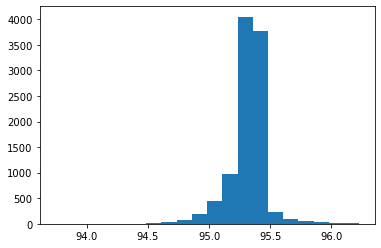

In [65]:
plt.hist(predict_real[:,0],20)

NameError: name 'tf' is not defined